In [116]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from scipy.stats import norm
from sklearn.utils import check_X_y, check_array
from sklearn.base import clone

class BoostedOrdinal(BaseEstimator, ClassifierMixin):
    def __init__(
        self
        , base_learner = DecisionTreeRegressor()
        , max_iter=100
        , lr_g = 1e-1
        , lr_theta = 1e-3
        , validation_fraction = 0.1
        , n_iter_no_change = None
        , reltol = 1e-2
    ):
        self.base_learner = base_learner
        self.max_iter = max_iter
        self.lr_g = lr_g
        self.lr_theta = lr_theta
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.reltol = reltol

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        if self.n_iter_no_change:
            X, X_holdout, y, y_holdout = train_test_split(X, y, test_size = self.validation_fraction)
        
        ylist = BoostedOrdinal._validate_ordinal(y)

        g_init, theta_init = BoostedOrdinal._initialize(y)
        loss_init = BoostedOrdinal._loss_function(X, y, g_init, theta_init)

        g, theta, loss = g_init, theta_init, loss_init
        loss_all = []
        learner_all = []
        intercept_all = []
        g_all = []
        theta_all = []

        if self.n_iter_no_change:
            loss_holdout = BoostedOrdinal._loss_function(X_holdout, y_holdout, g_init, theta_init)
            loss_all_holdout = []
            loss_all_holdout.append(loss_holdout)
            g_holdout = g_init

        loss_all.append(loss)
        g_all.append(np.repeat(g, y.size))
        theta_all.append(theta)

        no_change = False

        for p in range(self.max_iter):
            
            # update regression function
            dg = BoostedOrdinal._derivative_g(X, y, theta, g)
            weak_learner, h, intercept = BoostedOrdinal._fit_weak_learner(X, -dg, clone(self.base_learner))
            g = BoostedOrdinal._update_g(g, h, lr = self.lr_g)
            
            # update loss
            loss = BoostedOrdinal._loss_function(X, y, g, theta)
            loss_all.append(loss)
            
            # update threshold vector
            dtheta = BoostedOrdinal._derivative_threshold(X, ylist, theta, g)
            theta = BoostedOrdinal._update_thresh(theta, dtheta, lr = self.lr_theta)

            # update loss
            loss = BoostedOrdinal._loss_function(X, y, g, theta)
            loss_all.append(loss)
            
            learner_all.append(weak_learner)
            intercept_all.append(intercept)
            g_all.append(g)
            theta_all.append(theta)

            if self.n_iter_no_change:
                h_holdout = weak_learner.predict(X_holdout) + intercept
                g_holdout = BoostedOrdinal._update_g(g_holdout, h_holdout, lr = self.lr_g)
                loss_holdout = BoostedOrdinal._loss_function(X_holdout, y_holdout, g_holdout, theta)
                loss_all_holdout.append(loss_holdout)
                if len(loss_all_holdout) > self.n_iter_no_change:
                    if ((loss_all_holdout[-(1+self.n_iter_no_change)] - loss_all_holdout[-1]) / loss_all_holdout[-(1+self.n_iter_no_change)] < self.reltol):
                        no_change = True
                        break

        self.n_iter = p + 1 - self.n_iter_no_change if no_change else self.max_iter
        self.init = {'g': g_init, 'theta': theta_init, 'loss': loss_init}
        self.final = {'g': g, 'theta': theta, 'loss': loss_all[-1]}
        self.path = {
            'g': np.array(g_all), 'theta': np.array(theta_all), 'loss': np.array(loss_all)
            , 'learner': learner_all, 'intercept': np.array(intercept_all)
        }
        if self.n_iter_no_change:
            self.path['loss_holdout'] = np.array(loss_all_holdout)
        
        return self
    
    def predict(self, X, y = None, path = False, class_labels = True):
        check_array(X)
        arr = np.array([learner.predict(X) + self.path['intercept'][p] for p, learner in enumerate(self.path['learner'])])
        if path:
            arr = np.cumsum(arr, 0) * self.lr_g + self.init['g']
            if class_labels:
                tmp = [BoostedOrdinal._probabilities(arr[p, :], self.path['theta'][p+1], y) for p in range(arr.shape[0])]
                if class_labels:
                    if y is None:
                        return [BoostedOrdinal._class_labels(u) for u in tmp]
                    else:
                        return [(BoostedOrdinal._class_labels(u[0]), u[1]) for u in tmp]
                else:
                    return tmp
            else:
                return [BoostedOrdinal._probabilities(arr[p, :], self.path['theta'][p+1], y) for p in range(arr.shape[0])]
        else:
            arr = np.sum(arr[:self.n_iter, :], 0) * self.lr_g + self.init['g']
            tmp = BoostedOrdinal._probabilities(arr, self.path['theta'][-1], y)
            if class_labels:
                if y is None:
                    return BoostedOrdinal._class_labels(tmp)
                else:
                    return BoostedOrdinal._class_labels(tmp[0]), tmp[1]
                    
            else:
                return tmp

    def predict_proba(self, X):
        return self.predict(X, class_labels = False)

    def _class_labels(probs, axis = 1):
        return np.argmax(probs, axis = axis)
    
    def _probabilities(g, theta, y = None):
        probs = np.array([np.diff(norm.cdf(BoostedOrdinal._pad_thresholds(theta - x))) for x in g])

        if y is None:
            return probs
        
        loglike = sum([np.log(probs[n, yn]) for n, yn in enumerate(y)])
        return probs, loglike
    
    def _check_loss_change(loss):
        x = np.diff(loss)
        return (x[::2], x[1::2]) # (g, theta)
    
    
    def _validate_ordinal(arr):
        """
        Check if the unique values in a numpy integer vector are 0, 1, ..., M with M >= 2.
    
        Parameters:
        arr (numpy.ndarray): Input numpy integer vector.
    
        Returns:
        bool: True if unique values are 0, 1, ..., M with M >= 2, False otherwise.
        """
        if not isinstance(arr, np.ndarray):
            raise ValueError("Input must be a numpy array")
        if arr.dtype.kind not in {'i', 'u'}:
            raise ValueError("Input array must contain integers")
    
        unique_values = np.unique(arr)
        
        if unique_values[0] != 0:
            return []
        
        M = unique_values[-1]

        if M < 2:
            return []
        
        expected_values = np.arange(M + 1)

        if np.array_equal(unique_values, expected_values):
            #return M + 1
            return [np.where(arr == m) for m in unique_values]
        else:
            return []
    
    def _initialize(y):
        return (BoostedOrdinal._initialize_g(y), BoostedOrdinal._initialize_thresholds(y))
    
    def _initialize_g(y):
        #return np.zeros(y.size)
        return 0
    
    def _initialize_thresholds(y):
        # Calculate the initial threshold vector
        n_samples = len(y)
        n_class = np.max(y) + 1
        P = np.array([np.sum(y == i) for i in range(n_class)]) / n_samples
        return norm.ppf(np.cumsum(P[:-1]))
    
    def _pad_thresholds(theta):
        return np.insert(theta, [0, theta.size], [-np.inf, np.inf])
    
    def _derivative_threshold(X, ylist, thresh, g):
        thresh_padded = BoostedOrdinal._pad_thresholds(thresh)
        M = len(thresh)
        ret = []
        for m in range(M):
            S_m = ylist[m]
            S_mp1 = ylist[m+1]
            v1 = np.sum(norm.pdf(thresh_padded[m+1] - g[S_m]) / (norm.cdf(thresh_padded[m+1] - g[S_m]) - norm.cdf(thresh_padded[m] - g[S_m])))
            v2 = np.sum(norm.pdf(thresh_padded[m+1] - g[S_mp1]) / (norm.cdf(thresh_padded[m+2] - g[S_mp1]) - norm.cdf(thresh_padded[m+1] - g[S_mp1])))
            ret.append(-v1 + v2)
        return np.array(ret)

    def _derivative_g(X, y, thresh, g):
        thresh_padded = BoostedOrdinal._pad_thresholds(thresh)
        ret = (norm.pdf(thresh_padded[y+1] - g) - norm.pdf(thresh_padded[y] - g)) / (norm.cdf(thresh_padded[y+1] - g) - norm.cdf(thresh_padded[y] - g))
        return ret

    def _fit_weak_learner(X, pseudo_resids, learner):
        learner.fit(X, pseudo_resids)
        pred = learner.predict(X)
        intercept = -np.mean(pred) # we could also perform intercept adjustment in _update_g but mathematically the effect is the same
        return (learner, pred + intercept, intercept)
    
    # replace with more sophisticated version that performs line search
    def _update_g(g, h, lr = 1e-1):
        return g + lr * h
    
    # we need to check if updated thresh is valid (must be sorted) and handle invalid ones
    def _update_thresh(thresh, dthresh, lr = 1e-3):
        new_thresh = thresh - lr * dthresh
        if not np.all(np.diff(new_thresh)):
            raise ValueError("updated threshold vector invalid (must have strict ascending order)")
        return new_thresh
    
    # this can be fused with _probabilities, though this is likely more efficient is the goal is only loss and not the prob matrix
    def _loss_function(X, y, g, theta):
        theta_padded = BoostedOrdinal._pad_thresholds(theta)
        return -np.sum(np.log(norm.cdf(theta_padded[y + 1] - g) - norm.cdf(theta_padded[y] - g)))

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a sample dataset
X, y = make_classification(
    n_samples=1000, n_features=20, n_classes=3, n_informative=5
    #, random_state=1
)
indices = BoostedOrdinal._validate_ordinal(y)
#print(len(indices))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
    #, random_state=42
)

In [90]:
model = BoostedOrdinal(
    max_iter = 1000, lr_g = 1e-2, lr_theta = 1e-3
    , base_learner = DecisionTreeRegressor(max_depth = 6)
    , n_iter_no_change = 10
    #, reltol = -np.inf
).fit(X_train, y_train)

In [91]:
#model.path['loss_holdout']
model.n_iter

127

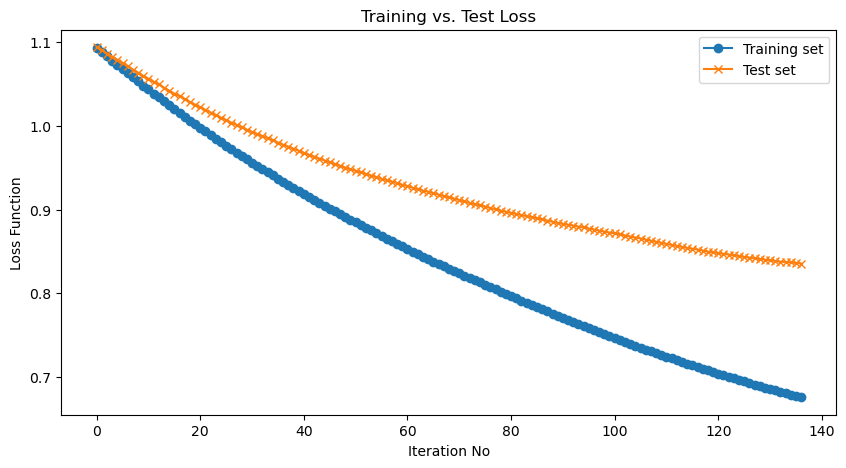

In [92]:
my_pred_test = model.predict(X_test, y_test, path = True, class_labels = False)
my_pred_train = model.predict(X_train, y_train, path = True, class_labels = False)

loss_train = -np.array([tmp[1] for tmp in my_pred_train]) / X_train.shape[0]
loss_test = -np.array([tmp[1] for tmp in my_pred_test]) / X_test.shape[0]

import matplotlib.pyplot as plt

indices = np.arange(len(loss_train))

# Create the plot
plt.figure(figsize=(10, 5))

# Plot the first array
plt.plot(indices, loss_train, label='Training set', marker='o')

# Plot the second array
plt.plot(indices, loss_test, label='Test set', marker='x')

# Add labels and title
plt.xlabel('Iteration No')
plt.ylabel('Loss Function')
plt.title('Training vs. Test Loss')
plt.legend()

# Show the plot
plt.show()


In [82]:
from sklearn.metrics import accuracy_score
from mord import LogisticIT

# Fit the ordered logistic regression model
mord_model = LogisticIT()
mord_model.fit(X_train, y_train)

# Predict the classes
y_pred_mord = mord_model.predict(X_test)

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred_mord)
#print(f'Accuracy: {accuracy}')


In [83]:
accuracy_score(y_train, mord_model.predict(X_train)), accuracy_score(y_test, mord_model.predict(X_test))

(0.5675, 0.585)

In [84]:
accuracy_score(y_train, model.predict(X_train)), accuracy_score(y_test, model.predict(X_test))

(0.8825, 0.755)

In [85]:
np.mean(y_test - y_pred_mord != 0), np.mean(abs(y_test - y_pred_mord))

(0.415, 0.45)

In [86]:
np.mean(y_test - model.predict(X_test) != 0), np.mean(abs(y_test - model.predict(X_test)))

(0.245, 0.3)

In [87]:
_, loss_test_selected = model.predict(X_test, y_test)
-loss_test_selected/y_test.size

0.7803136903546745

In [93]:
from sklearn.model_selection import GridSearchCV

In [103]:
parameters = {'base_learner__max_depth': [3, 6], 'lr_g': [1e-1, 1e-2]}

In [117]:
bor = BoostedOrdinal(n_iter_no_change = 10)
gscv = GridSearchCV(
    bor, parameters
    #, scoring = 'accuracy'
    , scoring = 'neg_log_loss'
)

In [118]:
gscv = gscv.fit(X_train, y_train)

In [119]:
accuracy_score(y_train, gscv.predict(X_train)), accuracy_score(y_test, gscv.predict(X_test))

(0.78625, 0.75)

In [120]:
gscv.best_estimator_.n_iter

58